# What can you reach in 15 minutes in DC?

This week, I want to hone in on what it would be like to live in the areas that could be called food deserts (i.e. the polygons that have at least 50% of households without a vehicle and are more than 10 minutes from the nearest grocery store). Taking the points calculated in the notebook "vehicle_access_clean," I will bring in the nearby nodes, create polygons using travel times of 5, 10, and 15 minutes, and then create isochrone maps with markers for food resources, which we mapped in other notebooks.

## Ward 2 Isochrone Map

I will use the information from the notebook, "vehicle_access_clean" where we found a variety of areas that are more than 10 minutes walking from a grocery store and have over 50% of households lacking vehicle access. I found the centroids of the polygons where these areas overlap and will use the following point randomly pulled from the list for Ward 2:

109    POINT (-77.03655 38.90197)

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx
import plotly.express as px
import osmnx as ox

In [2]:
latlon=[38.90197, -77.03655]
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75

Okay, now that we have set the parameters, let's bring in the nodes and networks.

In [3]:
G = ox.graph_from_point(latlon, network_type=network_type, dist = 2000)

Now, let's switch to a coordinate system to make it easier to measure distances.

In [4]:
G = ox.project_graph(G, to_crs='epsg:3857')

Next, I'll convert it into a geodata frame that extracts the nodes and edges we will need to define the street network.

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

Let's double check and see if the right points came through for the nodes.

In [6]:
gdf_nodes.sample(10)

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
8512220289,4.706272e+06,-8.573311e+06,3,-77.015359,38.892411,NaN,POINT (-8573310.547 4706272.039)
49793777,4.707548e+06,-8.576439e+06,4,-77.043463,38.901330,traffic_signals,POINT (-8576439.092 4707547.723)
8964459335,4.708231e+06,-8.577821e+06,3,-77.055873,38.906103,NaN,POINT (-8577820.545 4708230.558)
2791267327,4.708738e+06,-8.576611e+06,4,-77.045005,38.909652,crossing,POINT (-8576610.736 4708738.190)
9218467201,4.710174e+06,-8.574652e+06,1,-77.027413,38.919689,NaN,POINT (-8574652.437 4710174.288)
8481317108,4.706799e+06,-8.575910e+06,3,-77.038709,38.896096,NaN,POINT (-8575909.824 4706799.183)
8793803186,4.709991e+06,-8.573720e+06,3,-77.019038,38.918405,NaN,POINT (-8573720.125 4709990.548)
4805689272,4.709087e+06,-8.573952e+06,3,-77.021119,38.912089,NaN,POINT (-8573951.770 4709086.888)
3011566127,4.706605e+06,-8.573803e+06,4,-77.019786,38.894736,NaN,POINT (-8573803.381 4706604.633)


Looks good! Let's see what the nodes look like:

<AxesSubplot: >

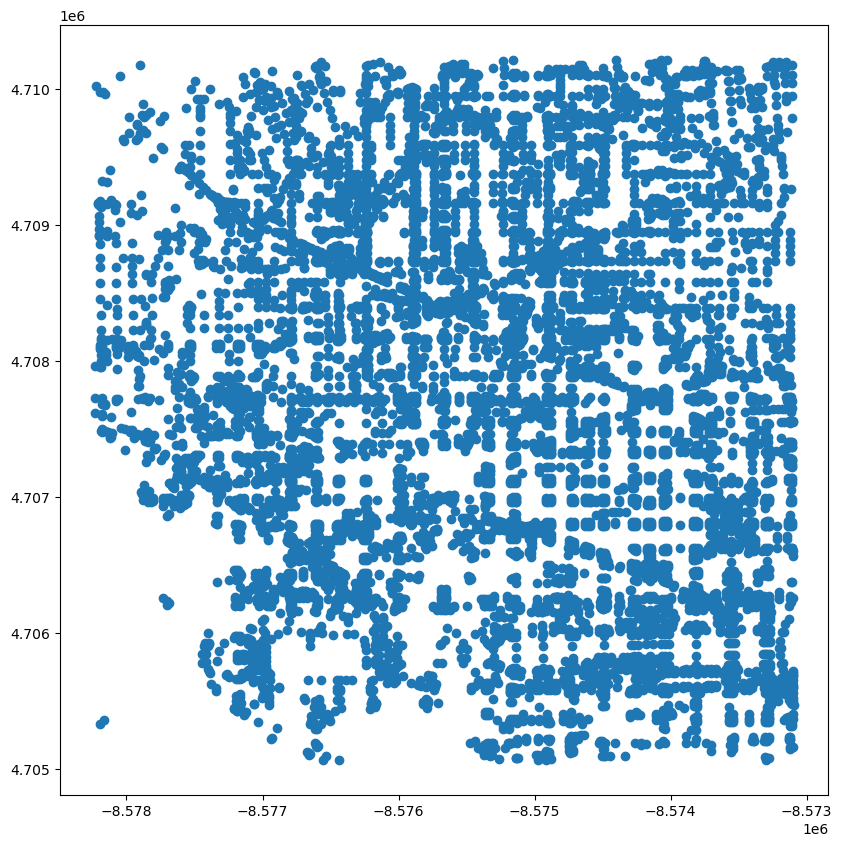

In [7]:
gdf_nodes.plot(figsize=(10,10))

So that could be anything, but it looks cool. Now I want to double check the edges to see what the street networks are and make sure we can use then to calculate walking distances.

In [8]:
gdf_edges.head()

osmid                     name      highway  \
u        v          key                                                    
49716899 49716904   0      6051300  Twining Court Northwest  residential   
         49779907   0    130889721       P Street Northwest    secondary   
         49741730   0    130889721       P Street Northwest    secondary   
49716904 49716899   0      6051300  Twining Court Northwest  residential   
         5447675534 0    161838107                      NaN      service   

                         oneway reversed  length lanes  \
u        v          key                                  
49716899 49716904   0     False    False  42.056   NaN   
         49779907   0     False    False  93.283     4   
         49741730   0     False     True  93.864     4   
49716904 49716899   0     False     True  42.056   NaN   
         5447675534 0     False     True  15.679   NaN   

                                                                  geometry  \
u        v          key                                                      
49716899 49716904   0    LINESTRING (-8576912.946 4708737.045, -8576913...   
         49779907   0    LINESTRING (-8576912.946 4708737.045, -8577021...   
         49741730   0    LINESTRING (-8576912.946 4708737.045, -8576805...   
49716904 49716899   0    LINESTRING (-8576913.469 4708682.941, -8576912...   
         5447675534 0    LINESTRING (-8576913.469 4708682.941, -8576913...   

                        service junction  ref maxspeed bridge width tunnel  \
u        v          key                                                      
49716899 49716904   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
         49779907   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
         49741730   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
49716904 49716899   0       NaN      NaN  NaN      NaN    NaN   NaN    NaN   
         5447675534 0     alley      NaN  NaN      NaN    NaN   NaN    NaN   

                        access  
u        v          key         
49716899 49716904   0      NaN  
         49779907   0      NaN  
         49741730   0      NaN  
49716904 49716899   0      NaN  
         5447675534 0      NaN

Ooh I recognize some of these roads! Now let's map the edges.

<AxesSubplot: >

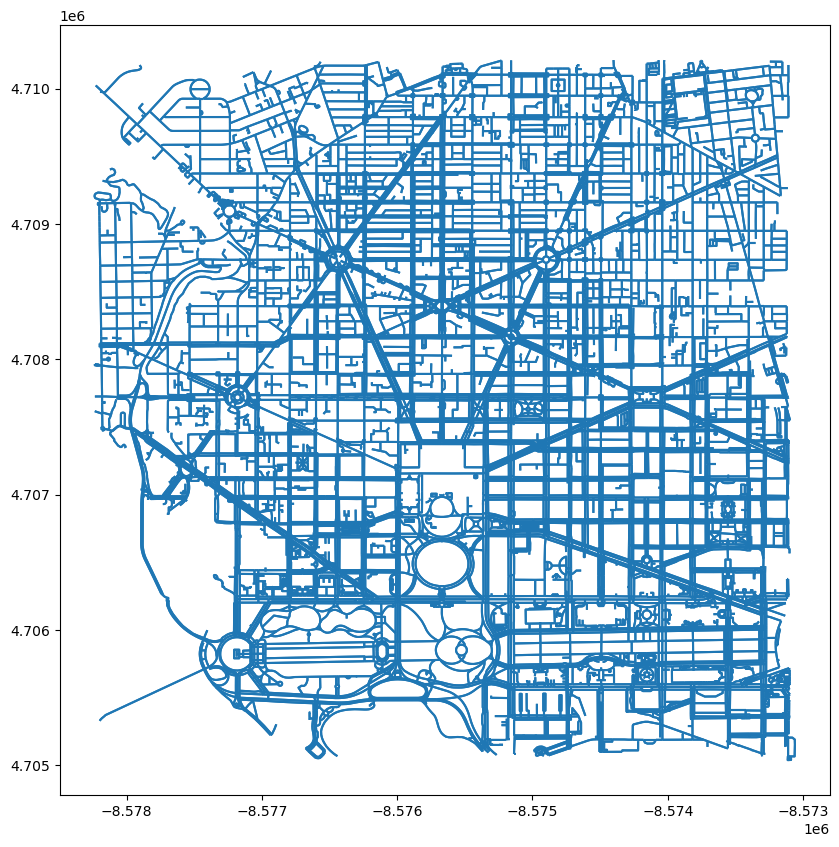

In [9]:
gdf_edges.plot(figsize=(10,10))

Cool, so we see the street network. Let's find the central node in the map by first mapping out the boundaries of the map:

In [10]:
minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
print(minx)
print(miny)
print(maxx)
print(maxy)

-8578234.698024705
4705066.960147139
-8573097.080885613
4710212.232952261


We'll calculate an average point that will become the centroid.

In [11]:
centroid_x = (maxx-minx)/2 + minx
centroid_y = (maxy-miny)/2 + miny
print(centroid_x)
print(centroid_y)

-8575665.889455158
4707639.5965497


In [12]:
ward2_node = ox.distance.nearest_nodes(G,Y=centroid_y,X=centroid_x)
print('The id for the nearest node is ' + str(ward2_node))

The id for the nearest node is 9983605761


In [13]:
gdf_nodes.loc[[ward2_node]]

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
9983605761,4.707635e+06,-8.575664e+06,3,-77.036502,38.901943,NaN,POINT (-8575664.209 4707635.494)


Now let's map it and see where it is in the network:

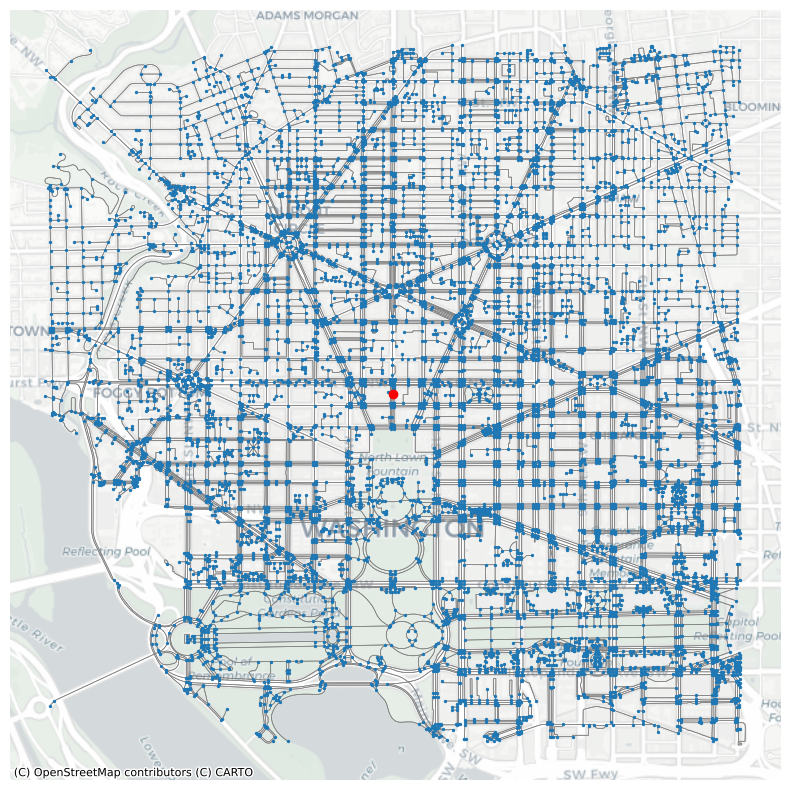

In [14]:
# set up the subplot (single plot = ax)
fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
gdf_edges.plot(ax=ax,
               linewidth=0.5,
               edgecolor='gray', 
               zorder=10)

# add all nodes to ax
gdf_nodes.plot(ax=ax, 
               markersize=2, 
               zorder=20)

# add the center node in red also to ax
gdf_nodes.loc[[ward2_node]].plot(ax=ax,
                                  color='r', 
                                  zorder=30)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron,zoom=14)

Oooh that's right in front of the White House park! I didn't think many people lived around that area.

## Making the Isochrone Map for Ward 2

I'm going to calculate walk times and then use that to create an isochrome map around Safeway. First, let's create a new column that calculates walking time under the assumption of 80 meters per minute.

In [15]:
gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

Now let's double check and see if the times came out accurately:

In [16]:
gdf_edges[['osmid','name','highway','length','walk_time']].sample(10)

,,,osmid,name,highway,length,walk_time
u,v,key,,,,,
9403945450,9403945449,0,1019608574,NaN,footway,12.956,0.172747
2462383183,4977488915,0,508442896,NaN,footway,20.300,0.270667
4117267834,6760336711,0,510537101,16th Street Northwest,primary,69.063,0.920840
3028067380,1866789042,0,298814321,NaN,footway,3.202,0.042693
5162340102,9643523212,0,1049360319,NaN,footway,21.776,0.290347
9403985719,9403985718,0,1019613418,NaN,footway,11.756,0.156747
5442031816,5442031803,0,564931821,NaN,path,2.648,0.035307
5445407423,10553265862,0,565410334,NaN,service,7.365,0.098200
49719415,706911255,0,6060664,28th Street Northwest,residential,33.960,0.452800


Now I want to create a color map that reflects distance to the grocery store:

In [17]:
cmap = 'YlGn'

Just want to double check that trip times are 5, 10, and 15 minutes.

In [18]:
trip_times

[5, 10, 15]

Let's use trip times to figure out what colors will be coded in each.

In [19]:
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap=cmap, 
                                start=0, 
                                return_hex=True)
print(trip_times)
print(iso_colors)

[5, 10, 15]
['#ffffe5', '#77c679', '#004529']


I actually want to invert these colors so that the dark green shows 5 minutes (#004529) while the lighter color reflects 15 minutes away.

In [20]:
new_colors=['#004529','#77c679','#ffffe5']
print(new_colors)

['#004529', '#77c679', '#ffffe5']


Let's try to zip these now to pair the list of trip times with the assigned colors:

In [21]:
time_color = list(zip(trip_times, new_colors))
time_color

[(5, '#004529'), (10, '#77c679'), (15, '#ffffe5')]

I'll use a loop to color the nodes around this point based on walking distance. I'll start by inversing the color order so that 15 minutes is first and then 5 minutes is last.

In [22]:
time_color.reverse()
time_color

[(15, '#ffffe5'), (10, '#77c679'), (5, '#004529')]

We want to create a for loop that connects each node within a time frame to a certain color. We'll create an egograph of nodes within this distance and then update the data frame for gdf_nodes with an associated distance color.

In [23]:
for time, color in list(time_color):
  
    subgraph = nx.ego_graph(G, ward2_node, radius=time,distance='time')

    print('There are ' + str(len(subgraph.nodes())) + ' nodes within ' + str(time) + ' minutes ' + color)
    
    for node in subgraph.nodes():
        gdf_nodes.loc[node,'time'] = time
        gdf_nodes.loc[node,'color'] = color

There are 493 nodes within 15 minutes #ffffe5
There are 199 nodes within 10 minutes #77c679
There are 49 nodes within 5 minutes #004529


I want to check gdf_nodes for missing values and assign a color to those:

In [24]:
gdf_nodes.sample(10)

,y,x,street_count,lon,lat,highway,geometry,time,color
osmid,,,,,,,,,
49785433,4.708395e+06,-8.575541e+06,3,-77.035394,38.907251,NaN,POINT (-8575540.833 4708394.826),NaN,NaN
3957027898,4.708750e+06,-8.575680e+06,4,-77.036646,38.909733,NaN,POINT (-8575680.149 4708749.864),NaN,NaN
8451914567,4.706199e+06,-8.573817e+06,3,-77.019913,38.891899,NaN,POINT (-8573817.463 4706198.782),NaN,NaN
5445407459,4.707852e+06,-8.573737e+06,3,-77.019192,38.903457,NaN,POINT (-8573737.279 4707852.093),NaN,NaN
1825446964,4.707549e+06,-8.575438e+06,4,-77.034472,38.901337,crossing,POINT (-8575438.197 4707548.853),10.0,#77c679
9668387126,4.709731e+06,-8.574473e+06,3,-77.025799,38.916589,NaN,POINT (-8574472.745 4709730.667),NaN,NaN
8311910987,4.705788e+06,-8.574546e+06,4,-77.026459,38.889028,NaN,POINT (-8574546.193 4705788.214),NaN,NaN
8776517197,4.709678e+06,-8.574024e+06,3,-77.021772,38.916218,crossing,POINT (-8574024.472 4709677.673),NaN,NaN
5447675249,4.708630e+06,-8.577859e+06,1,-77.056214,38.908897,NaN,POINT (-8577858.561 4708630.295),NaN,NaN


We'll make those nodes outside of the 15-minute radius gray so they are visible.

In [25]:
gdf_nodes['color'].fillna('#cccccc', inplace=True)
gdf_nodes.sample(10)

,y,x,street_count,lon,lat,highway,geometry,time,color
osmid,,,,,,,,,
49773012,4.707781e+06,-8.574040e+06,5,-77.021915,38.902957,traffic_signals,POINT (-8574040.369 4707780.584),NaN,#cccccc
5556913194,4.706275e+06,-8.574175e+06,1,-77.023123,38.892431,NaN,POINT (-8574174.854 4706274.914),NaN,#cccccc
2790623981,4.707570e+06,-8.574509e+06,4,-77.026125,38.901486,crossing,POINT (-8574509.002 4707570.067),NaN,#cccccc
8512220283,4.706254e+06,-8.573364e+06,3,-77.015835,38.892283,NaN,POINT (-8573363.569 4706253.703),NaN,#cccccc
5447675311,4.708684e+06,-8.577033e+06,3,-77.048797,38.909270,NaN,POINT (-8577032.882 4708683.599),NaN,#cccccc
8319508752,4.705826e+06,-8.574442e+06,3,-77.025520,38.889294,NaN,POINT (-8574441.620 4705826.257),NaN,#cccccc
5445790037,4.707438e+06,-8.575564e+06,1,-77.035600,38.900563,NaN,POINT (-8575563.809 4707438.139),10.0,#77c679
9313418649,4.706624e+06,-8.573107e+06,3,-77.013531,38.894873,NaN,POINT (-8573107.022 4706624.214),NaN,#cccccc
4975134041,4.705462e+06,-8.574494e+06,3,-77.025988,38.886746,NaN,POINT (-8574493.762 4705461.868),NaN,#cccccc


Now that all nodes should have a color, let's plot it using plotly.

<AxesSubplot: >

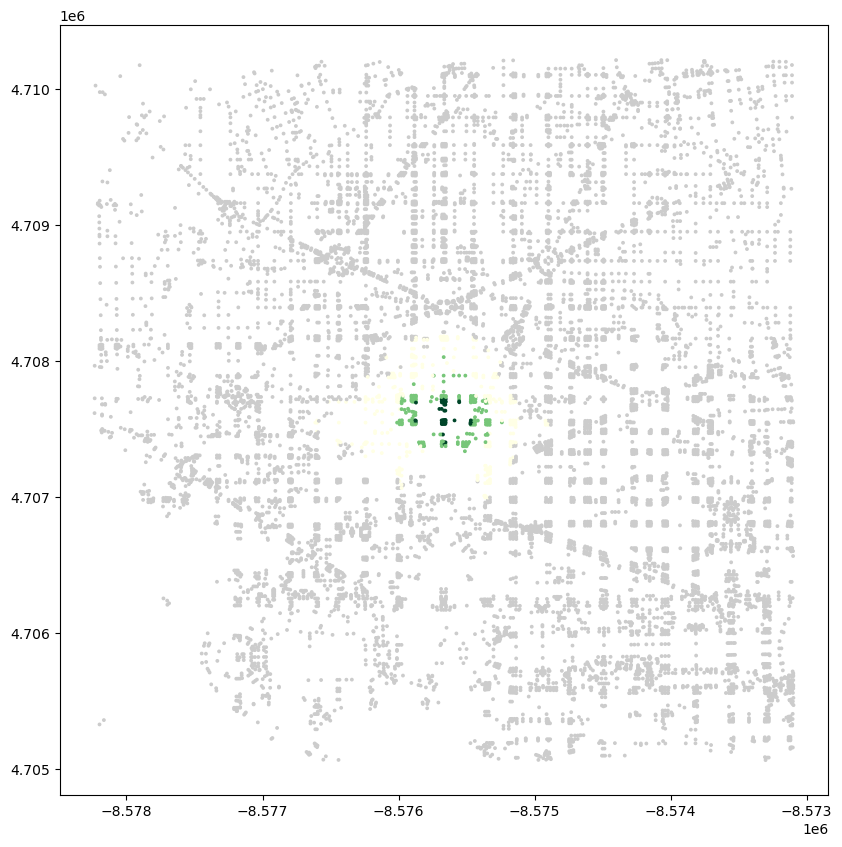

In [26]:
gdf_nodes.plot(figsize=(10,10),
               color=gdf_nodes['color'],
               markersize=3,
               )

Now let's make the polygon around these nodes.

## Creating the Polygons

First, I'll start out with creating the polygon around points for 5 minute walking distance.

In [27]:
gdf_5 = gdf_nodes[gdf_nodes['time']==5]

Let's plot it and see what points are formed...

<AxesSubplot: >

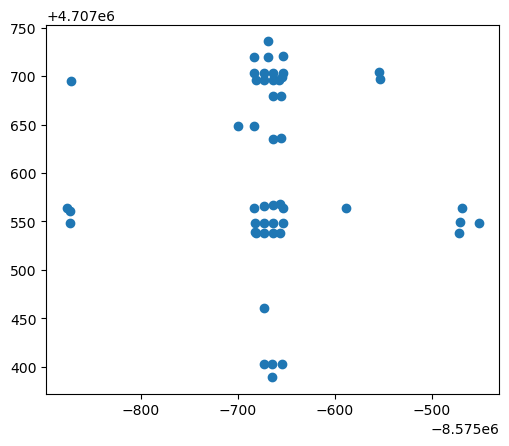

In [28]:
gdf_5.plot()

Let's see what shape it forms using a convex-hull to connect the area between the nodes.

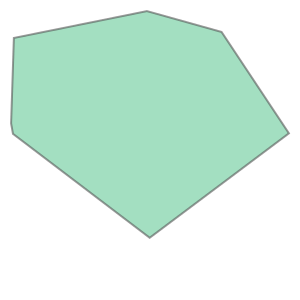

In [29]:
gdf_5.unary_union.convex_hull

Well....that's something. Let's hope the other shapes provide more insight into what's going on around this point. I'll use dissolve for this next part to create polygons around the 5, 10, and 15 minute nodes.

In [30]:
isochrones = gdf_nodes.dissolve(by = "time")
isochrones

,geometry,y,x,street_count,lon,lat,highway,color
time,,,,,,,,
5.0,"MULTIPOINT (-8575876.528 4707564.130, -8575873...",4.707549e+06,-8.575452e+06,4,-77.034593,38.901338,traffic_signals,#004529
10.0,"MULTIPOINT (-8576010.780 4707547.680, -8575992...",4.707389e+06,-8.575828e+06,4,-77.037974,38.900223,traffic_signals,#77c679
15.0,"MULTIPOINT (-8576612.049 4707547.566, -8576599...",4.707292e+06,-8.575158e+06,4,-77.031952,38.899540,crossing,#ffffe5


We'll convert each row into a convex hull now using the geometry of the multiple nodes.

In [31]:
isochrones = isochrones.convex_hull.reset_index(name='geometry')
isochrones

,time,geometry
0,5.0,"POLYGON ((-8575664.598 4707389.205, -8575873.6..."
1,10.0,"POLYGON ((-8575512.458 4707337.325, -8575824.0..."
2,15.0,"POLYGON ((-8575362.700 4706996.740, -8575978.1..."


Now, I'll reverse the order so the 15 minute polygon is mapped first.

In [32]:
isochrones.sort_values(by='time', ascending=False,inplace=True)
isochrones

,time,geometry
2,15.0,"POLYGON ((-8575362.700 4706996.740, -8575978.1..."
1,10.0,"POLYGON ((-8575512.458 4707337.325, -8575824.0..."
0,5.0,"POLYGON ((-8575664.598 4707389.205, -8575873.6..."


Time to plot it and see what is produces!

<AxesSubplot: >

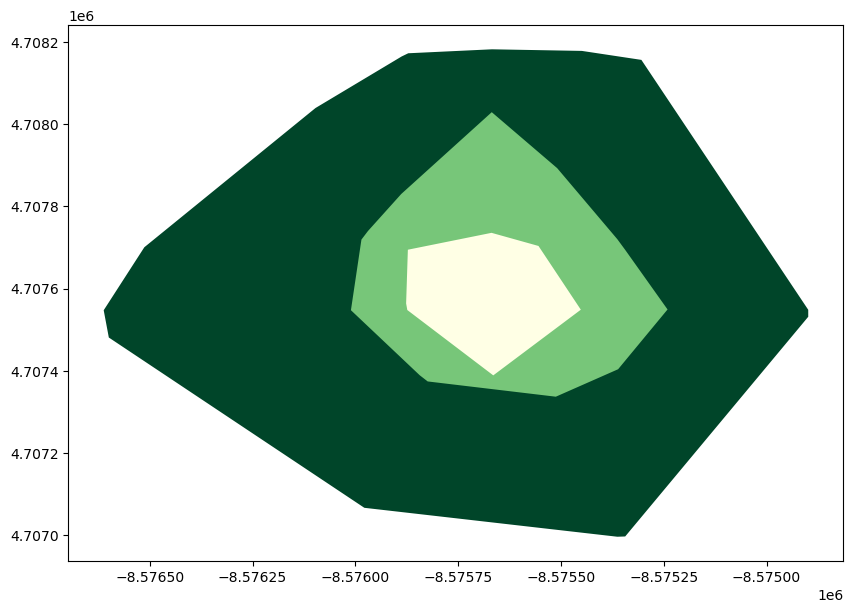

In [33]:
isochrones.plot(figsize=(10,10),alpha=1,color=new_colors, legend=True)

Let's map it into a base map. I'll add a marker for the central node that the distances were calculated from.

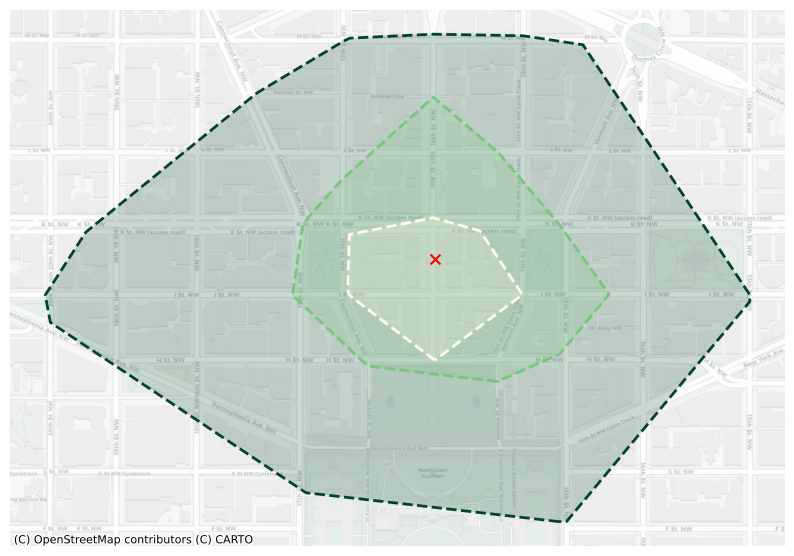

In [34]:
# set up the subplots
fig, ax = plt.subplots(figsize=(10,15))

# add the isochrone boundary
isochrones.boundary.plot(
    ax=ax,
    alpha=1,
    linestyle='--',
    color=new_colors,
    lw=2
    ) 

# add the isochrones
isochrones.plot(
    ax=ax, 
    alpha=0.2, 
    categorical=True, # even though it is numeric, treat it as categorical
    color=new_colors,
    )

# add the center node in red
gdf_nodes.loc[[ward2_node]].plot(ax=ax,color='r',marker='x',markersize=50)

# hide the axis
ax.axis('off')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Adding in Food Environment Markers to Maps

Now, I'll quickly bring in the data for grocery stores, farmers markets, fast food, liquor licenses, and community gardens to plot them as markers within the isochrone map.

Let's start with grocery stores...

In [35]:
grocery = pd.read_csv('data/Grocery_Store_Locations.csv')

Don't need to clean up everything because I know that we just need the coordinates in order to map everything. I'll turn it into a geodata frame now.

In [36]:
gdf_grocery = gpd.GeoDataFrame(grocery, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(grocery.X, grocery.Y))

In [37]:
gdf_grocery.head()

,X,Y,STORENAME,ADDRESS,ZIPCODE,PHONE,WARD,SSL,NOTES,PRESENT90,...,YCOORD,MAR_ID,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,PRESENT22,geometry
0,-77.026981,38.984455,Target,7828 GEORGIA AVENUE NW,20012,2028923822,Ward 4,2960 0017,NaN,NaN,...,146280.07,300512,NaN,{CE302122-4E8D-4DC7-845B-06563B993F66},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.027 38.984)
1,-77.026066,38.983464,International Progresso Market,7719 GEORGIA AVENUE NW,20012,2025455015,Ward 4,2961 0810,NaN,NaN,...,146169.97,285417,NaN,{2C18863D-40DE-4F66-AA59-46F1C65D67F2},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.026 38.983)
2,-77.027798,38.967771,Jocelyn’s Market,6404 GEORGIA AVENUE NW,20012,2027227574,Ward 4,2945 0839,NaN,NaN,...,144428.00,285334,NaN,{A0B448C3-B3FB-49FE-B8BF-1FEBA3CEA642},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.028 38.968)
3,-77.076459,38.965553,Magruder's,5626 CONNECTICUT AVENUE NW,20015,2024644946,Ward 3,1860 0013,,Yes,...,144184.19,263860,NaN,{9ABE1C46-BB48-4110-B5BA-C6363CA3BD7A},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.076 38.966)
4,-77.074910,38.964601,Safeway,5545 CONNECTICUT AVENUE NW,20015,2022446097,Ward 3,1867 0092,,No,...,144078.34,263999,NaN,{902F540E-FE16-43A5-8010-CD84E94B28B7},JLAY,2022/09/28 18:04:54+00,JLAY,2022/09/28 18:04:54+00,Yes,POINT (-77.075 38.965)


Repeating the process of bringing in farmers markets and turning it into a geodata frame:

In [38]:
farmers = pd.read_csv('data/Farmers_Market_Locations.csv')

In [39]:
gdf_farmers=gpd.GeoDataFrame(farmers, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(farmers.X, farmers.Y))

In [40]:
gdf_farmers.head()

,X,Y,NAME,LAYER,THEME,IMAGE_,ADDRESS,PHONE,VOUCHERS,PRIORITY_LEVEL,...,SE_ANNO_CAD_DATA,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,LATITUDE,LONGITUDE,geometry
0,-77.075111,38.965166,Chevy Chase/Broad Branch Farmers' Market,Farmers Market,Local Business & Food,NaN,5601 Connecticut Ave. NW,NaN,NaN,NaN,...,NaN,FarmersMarketPt_9,{BA7F2149-421B-4053-9C2F-25BD6C2062D6},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.965159,-77.075109,POINT (-77.075 38.965)
1,-77.033134,38.955829,14th & Kennedy Farmers' Market,Farmers Market,Local Business & Food,NaN,5425 14th St NW,NaN,"Accepts SNAP, WIC and senior farmers market nu...",NaN,...,NaN,FarmersMarketPt_10,{81DB3732-F194-4E23-BD85-4C01FFBA5870},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.955822,-77.033132,POINT (-77.033 38.956)
2,-77.069967,38.947004,New Morning Farmers Market at the Sheridan School,Farmers Market,Local Business & Food,NaN,3600 Alton Place NW,814.448.3904,"Accepts WIC, senior farmers market nutrition p...",1.0,...,NaN,FarmersMarketPt_11,{A796CC2A-E688-4F90-8628-6B1B98172BC2},NaN,NaN,DCGIS,2018/01/03 16:49:14+00,38.946996,-77.069965,POINT (-77.070 38.947)
3,-77.064407,38.944128,UDC Farmers Market,Farmers Market,Local Business & Food,NaN,4200 Connecticut Ave NW,202-274-7148,"Accepts SNAP, WIC and senior farmers market nu...",NaN,...,NaN,FarmersMarketPt_12,{0EB6EBBC-82CC-40A2-B5D1-E9B94D306B24},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.944120,-77.064405,POINT (-77.064 38.944)
4,-77.024775,38.941371,Petworth Community Market,Farmers Market,Local Business & Food,NaN,4121 9th St NW,NaN,"Accepts SNAP, WIC and senior farmers market nu...",NaN,...,NaN,FarmersMarketPt_13,{77E47183-0DCC-4E49-BC54-56780B300A2B},NaN,NaN,DCGIS,2018/01/03 16:47:52+00,38.941364,-77.024772,POINT (-77.025 38.941)


Let's repeat the importing and converting into a geodataframe process for fast food:

In [41]:
fast = pd.read_csv('data/Fast Food Data.csv')

In [42]:
fast.rename(columns={'Geometry':'geometry'}, inplace=True)
fast.rename(columns={'Store Name':'NAME'}, inplace=True)

Time to convert it into a geodata frame.

In [43]:
gdf_fast = gpd.GeoDataFrame(fast, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(fast.Longitude, fast.Latitude))

In [44]:
gdf_fast.head()

,NAME,Store Type,geometry,Latitude,Longitude,Address
0,McDonalds,fast food,POINT (-77.077 38.945),38.944559,-77.077161,"4130 Wisconsin Ave NW, Washington, DC 20016"
1,McDonalds,fast food,POINT (-77.026 38.983),38.982652,-77.025704,"7425 Georgia Ave NW, Washington, DC 20011"
2,McDonalds,fast food,POINT (-77.028 38.963),38.963234,-77.028193,"5948 Georgia Ave NW, Washington, DC 20011"
3,McDonalds,fast food,POINT (-77.052 38.927),38.926756,-77.051582,"2616 Connecticut Ave NW, Washington, DC 20008"
4,McDonalds,fast food,POINT (-77.042 38.924),38.923718,-77.042184,"2481-83 18th St NW, Washington, DC 20009"


I actually want to distinguish between "healthy" and "unhealthy" fast food so let me go ahead and create two separate variables for that.

In [45]:
fast_unhealthy=gdf_fast[gdf_fast['Store Type']=='fast food']
fast_healthy=gdf_fast[gdf_fast['Store Type']=='healthy fast food']

Repeat for liquor licenses:

In [46]:
liquor= pd.read_csv('data/Liquor_Licenses.csv')

In [47]:
gdf_liquor=gpd.GeoDataFrame(liquor, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(liquor.X, liquor.Y))

In [48]:
gdf_liquor.head()

,X,Y,LICENSE,APPLICANT,TRADE_NAME,CLASS,ADDRESS,ZIPCODE,WARD,ANC,...,LONGITUDE,LATITUDE,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,geometry
0,-77.045099,38.913006,ABRA-011228,R Street Restaurant Corporation,La Tomate,C,1701 CONNECTICUT AVENUE NW,20009,Ward 2,ANC 2B,...,-77.045097,38.912999,ABRALicenseePt_91,{3E350BC9-82F1-48D5-9A08-BDD89B642F69},JLAY,2022/08/31 18:04:53+00,JLAY,2022/08/31 18:04:53+00,4891,POINT (-77.045 38.913)
1,-77.049072,38.904526,ABRA-060273,"MPE Hotel I (Washington), LLC",Ritz Carlton Washington DC,C,1150 22ND STREET NW,20037,Ward 2,ANC 2A,...,-77.049070,38.904519,ABRALicenseePt_228,{68D32801-8631-4B1A-93FB-3313C7F6BBD5},JLAY,2022/08/31 18:04:53+00,JLAY,2022/08/31 18:04:53+00,5028,POINT (-77.049 38.905)
2,-77.031698,38.896532,ABRA-076197,"Lim Enterprises, Corp",Press Liquors,A,527 14TH STREET NW,20004,Ward 2,ANC 2C,...,-77.031695,38.896525,ABRALicenseePt_406,{F0CCB31F-D68E-47FA-8991-D8EC265259F1},JLAY,2022/08/31 18:04:53+00,JLAY,2023/02/03 22:20:23+00,5206,POINT (-77.032 38.897)
3,-77.021170,38.936862,ABRA-091449,"A & M, Inc.",Rock Creek Market,B,646 ROCK CREEK CHURCH ROAD NW,20010,Ward 1,ANC 1E,...,-77.021168,38.936854,ABRALicenseePt_777,{216F37CB-096C-4176-976B-3F31E89509B9},JLAY,2022/08/31 18:04:53+00,JLAY,2023/02/03 22:20:23+00,5577,POINT (-77.021 38.937)
4,-77.045210,38.911322,ABRA-102667,Aaron C. Dutton,Dupont Circle FreshFarm Market,Caterer,1600 20TH STREET NW,20009,Ward 2,ANC 2B,...,-77.045207,38.911315,ABRALicenseePt_1104,{345AE1AE-E085-4823-9713-E0244AB52E09},JLAY,2022/08/31 18:04:53+00,JLAY,2022/08/31 18:04:53+00,5904,POINT (-77.045 38.911)


I only want to display Class A liquor licenses, which are retailers (not in grocery stores). Let's make that a separate variable.

In [49]:
liquor_stores=gdf_liquor[gdf_liquor['CLASS']=='A']

Now, moving onto community gardens:

In [50]:
garden=pd.read_csv('data/Community_Gardens.csv')

In [51]:
garden.head()

,X,Y,OBJECTID,ADDRESS,NAME,PLOTS,ORGANIZATION,XCOORD,YCOORD,MAR_ID,...,WEB_URL,COMMENTS,LATITUDE,LONGITUDE,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED
0,-77.030970,38.970534,1,1327 VAN BUREN STREET NW,Ft. Stevens Garden,9.0,DPR,397305.720000,144706.250000,290152.0,...,http://dpr.dc.gov/page/dpr-community-gardens,,38.970527,-77.030967,CommunityGardenPt_1,{D424973D-2F1D-4E71-A332-569D43EB7F8D},NaN,NaN,NaN,NaN
1,-77.018054,38.968894,2,300 VAN BUREN STREET NW,Takoma Garden,11.0,DPR,398435.640000,144552.480000,296168.0,...,NaN,NaN,38.968887,-77.018052,CommunityGardenPt_2,{3F59A195-CC57-4949-A6B5-A7DDCF90E34A},NaN,NaN,NaN,NaN
2,-77.053620,38.966723,3,OREGON AVENUE NW AND NORTHAMPTON STREET NW,Rock Creek Garden,NaN,NPS,395310.599994,144382.980003,904431.0,...,http://dcgardens.com/community-gardens/,,38.966715,-77.053617,CommunityGardenPt_3,{D0518FF8-FE38-47B1-8050-B9CB8EA71957},NaN,NaN,NaN,NaN
3,-77.030469,38.963683,4,13TH STREET NW AND FORT STEVENS DRIVE NW,Fort Stevens Community Garden,NaN,NPS,397396.079996,144052.680003,903937.0,...,NaN,NaN,38.963675,-77.030467,CommunityGardenPt_4,{82825E83-2272-4131-9607-99AFC1924849},NaN,NaN,NaN,NaN
4,-77.025289,38.963038,5,8TH STREET NW AND PEABODY STREET NW,Peabody Garden,NaN,NPS,397902.050012,143865.950019,901763.0,...,http://dcgardens.com/community-gardens/,,38.963030,-77.025286,CommunityGardenPt_5,{68F17929-52CD-43A4-9A55-E8DE58CC2429},NaN,NaN,NaN,NaN


In [52]:
gdf_garden=gpd.GeoDataFrame(garden, 
                       crs='epsg:3857',
                       geometry=gpd.points_from_xy(garden.X, garden.Y))

In [53]:
gdf_garden.head()

,X,Y,OBJECTID,ADDRESS,NAME,PLOTS,ORGANIZATION,XCOORD,YCOORD,MAR_ID,...,COMMENTS,LATITUDE,LONGITUDE,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,geometry
0,-77.030970,38.970534,1,1327 VAN BUREN STREET NW,Ft. Stevens Garden,9.0,DPR,397305.720000,144706.250000,290152.0,...,,38.970527,-77.030967,CommunityGardenPt_1,{D424973D-2F1D-4E71-A332-569D43EB7F8D},NaN,NaN,NaN,NaN,POINT (-77.031 38.971)
1,-77.018054,38.968894,2,300 VAN BUREN STREET NW,Takoma Garden,11.0,DPR,398435.640000,144552.480000,296168.0,...,NaN,38.968887,-77.018052,CommunityGardenPt_2,{3F59A195-CC57-4949-A6B5-A7DDCF90E34A},NaN,NaN,NaN,NaN,POINT (-77.018 38.969)
2,-77.053620,38.966723,3,OREGON AVENUE NW AND NORTHAMPTON STREET NW,Rock Creek Garden,NaN,NPS,395310.599994,144382.980003,904431.0,...,,38.966715,-77.053617,CommunityGardenPt_3,{D0518FF8-FE38-47B1-8050-B9CB8EA71957},NaN,NaN,NaN,NaN,POINT (-77.054 38.967)
3,-77.030469,38.963683,4,13TH STREET NW AND FORT STEVENS DRIVE NW,Fort Stevens Community Garden,NaN,NPS,397396.079996,144052.680003,903937.0,...,NaN,38.963675,-77.030467,CommunityGardenPt_4,{82825E83-2272-4131-9607-99AFC1924849},NaN,NaN,NaN,NaN,POINT (-77.030 38.964)
4,-77.025289,38.963038,5,8TH STREET NW AND PEABODY STREET NW,Peabody Garden,NaN,NPS,397902.050012,143865.950019,901763.0,...,,38.963030,-77.025286,CommunityGardenPt_5,{68F17929-52CD-43A4-9A55-E8DE58CC2429},NaN,NaN,NaN,NaN,POINT (-77.025 38.963)


## Adding Food Environment to the Isochrone Maps

Now that we have these geodata frames ready to go, let's add them to an interactive folium map!

In [54]:
m = folium.Map(location=latlon,zoom_start=15, tiles='Stamen Terrain')

m = folium.Map(location=[38.90197, -77.03655],
               zoom_start = 20,
               tiles='CartoDB positron', 
               attribution='CartoDB')

isochrones.explore(m=m,name="Walking Distances in Ward 2 food desert",column='time',cmap=cmap,categorical=True)


m2=folium.FeatureGroup(name= "Grocery Stores").add_to(m)
for index, row in gdf_grocery.iterrows():
    folium.Marker([row.Y, row.X], popup=row.STORENAME, tooltip=row.STORENAME, icon=folium.Icon(color='green',icon_color='white', icon='shopping-cart')).add_to(m2)

m3=folium.FeatureGroup(name= "Farmers Markets").add_to(m)
for index, row in gdf_farmers.iterrows():
    folium.Marker([row.Y, row.X], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon_color='white', icon='leaf')).add_to(m3)

m4=folium.FeatureGroup(name= "Community Gardens").add_to(m)
for index, row in gdf_garden.iterrows():
    folium.Marker([row.Y, row.X], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon='tree-deciduous')).add_to(m4)

m5=folium.FeatureGroup(name= "Healthy Fast Food").add_to(m)
for index, row in fast_healthy.iterrows():
    folium.Marker([row.Latitude, row.Longitude], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='green', icon='cutlery')).add_to(m5)
    
m6=folium.FeatureGroup(name= "Unhealthy Fast Food").add_to(m)
for index, row in fast_unhealthy.iterrows():
    folium.Marker([row.Latitude, row.Longitude], popup=row.NAME, tooltip=row.NAME, icon=folium.Icon(color='black', icon='cutlery')).add_to(m6)
    
m7=folium.FeatureGroup(name= "Liquor Stores").add_to(m)
for index, row in liquor_stores.iterrows():
    folium.Marker([row.Y, row.X], popup=row.TRADE_NAME, tooltip=row.TRADE_NAME, icon=folium.Icon(color='black', icon='glass')).add_to(m7)

folium.LayerControl().add_to(m)
m

What's interesting to see here is that in this food desert, which is actually located right in front of the White House in downtown DC, there are actually other food options nearby. Liquor stores and 'unhealthy' fast food chains outnumber the Subways and two farmers markets in the area.

In [55]:
m.save('Ward2isochronemap.html')